<a href="https://colab.research.google.com/github/woojin9605/Practice/blob/main/Classifier_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CIFAR-10 Classifier

VGG-16을 CIFAR-10데이터에 맞게 레이어 수정하여 구현

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision
import torchvision.datasets as dset
import torchvision.transforms as T

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# load train dataset

Num_Train = 49000
BatchSize = 64

transform = T.Compose([
              T.ToTensor(),
              T.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
]) # 데이터 정규화

cifar10_train = dset.CIFAR10(root='drive/MyDrive/Classifier_based_CNN/CIFAR-10/',train=True,
                             download=True,transform=transform)
loader_train = DataLoader(cifar10_train,batch_size=BatchSize,
                          sampler=sampler.SubsetRandomSampler(range(Num_Train)))

cifar10_val = dset.CIFAR10('drive/MyDrive/Classifier_based_CNN/CIFAR-10/',train=True,
                           download=True,transform=transform)
loader_val = DataLoader(cifar10_val,batch_size=BatchSize,
                          sampler=sampler.SubsetRandomSampler(range(Num_Train,50000)))

cifar10_test = dset.CIFAR10('drive/MyDrive/Classifier_based_CNN/CIFAR-10/',train=True,
                           download=True,transform=transform)
loader_test = DataLoader(cifar10_test, batch_size=64)

classes = ('plane','car','bird','cat',
           'deer','dog','frog','horse','ship','truck')

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# Use GPU

dtype = torch.float32
device = torch.device('cuda')
#device = torch.device('cpu') # if using cpu
print('device :', device)

device : cuda


In [ ]:
# model architecture 및 optimizer 정의

def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)
class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)

model = None
optimizer = None
learning_rate = 1e-4
betas = [0.9, 0.999]

layers_key = [64, 64, 'M', 128, 128, 256, 256, 256, 'M', 512, 512, 512, 512, 512, 512, 'M']
layers = [] # 대부분의 레이어는 유지. MaxPool 레이어만 제거
in_channels = 3

for i in layers_key: # generate nn.Sequential layers
  if i == 'M':
    layers += [nn.MaxPool2d(2,2)]
  else:
    layers += [nn.Conv2d(in_channels,i,3,padding=1), nn.BatchNorm2d(i), nn.ReLU()]
    in_channels = i

#print(layers)

model = nn.Sequential(
    *layers,
    Flatten(),
    nn.Linear(512*4*4,4096),
    nn.ReLU(),
    nn.Dropout(), # default p = 0.5
    nn.Linear(4096,4096),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(4096,10)
)

#print(model)

optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=betas)

In [ ]:
# training model
# 이미 pre-trained model이 있으므로 해당 셀은 생략 가능


model = model.to(device=device)
print_every = 1000
epochs = 10
lr_sche = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.8) # lr decay

for e in range(epochs): # training
  for t,(x,y) in enumerate(loader_train):
    model.train() #model contain batchnorm, dropout etc. 모델에게 train상태임을 알려줌
    x = x.to(device=device, dtype=dtype)
    y = y.to(device=device, dtype=torch.long)

    scores = model(x)
    loss = F.cross_entropy(scores,y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if t % print_every == 0:
      print('iter %d, loss = %.4f' % (t, loss.item()))
  lr_sche.step()

print('training finished, loss = %.4f' % loss.item())
#model.state_dict()

# 학습된 model parameters 저장
torch.save(model.state_dict(),'drive/MyDrive/Classifier_based_CNN/model.pt') # save model parameters


"\nmodel = model.to(device=device)\nprint_every = 1000\nepochs = 10\nlr_sche = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.8) # lr decay\n\nfor e in range(epochs): # training\n  for t,(x,y) in enumerate(loader_train):\n    model.train() #model contain batchnorm, dropout etc. 모델에게 train상태임을 알려줌\n    x = x.to(device=device, dtype=dtype)\n    y = y.to(device=device, dtype=torch.long)\n\n    scores = model(x)\n    loss = F.cross_entropy(scores,y)\n\n    optimizer.zero_grad()\n    loss.backward()\n    optimizer.step()\n\n    if t % print_every == 0:\n      print('iter %d, loss = %.4f' % (t, loss.item()))\n  lr_sche.step()\n\nprint('training finished, loss = %.4f' % loss.item())\n#model.state_dict()\n\n# 학습된 model parameters 저장\ntorch.save(model.state_dict(),'drive/MyDrive/Classifier_based_CNN/model.pt') # save model parameters\n"

In [ ]:
# 새로운 모델 생성 후 저장된 parameter load

# When you load trained model
model_state_dict = torch.load('drive/MyDrive/Classifier_based_CNN/model.pt') # pre-trained parameters
new_model = model
new_model.load_state_dict(model_state_dict) # load pre-trained parameters

<All keys matched successfully>

In [ ]:
# accuracy test

new_model = new_model.to(device=device)
new_model.eval()
num_correct = 0
num_samples = 0

for (x,y) in loader_val:
      x = x.to(device=device, dtype=dtype)
      y = y.to(device=device, dtype=torch.long)

      scores = new_model(x)
      _, predicts = torch.max(scores,dim=1)

      num_correct += torch.sum(predicts == y)
      num_samples += predicts.size(0)

acc = float(num_correct) / num_samples
print('correct : %d / %d , acc (%.2f)' % (num_correct,num_samples,100*acc))

correct : 848 / 1000 , acc (84.80)


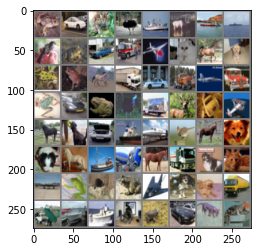

Ground_Truth :   frog  car  cat bird ship deer ship ship bird frog  cartruckplane  cathorse  dog frog froghorsetruck  cartruckplane  car frog  car frog birdtruck deer  carplanehorse  dog  car shipplane birdhorse  dog  doghorse shiptruckhorsetruck  cat  catplane frog  cat frogplane  dog  dogtrucktruck ship ship  cat frog  car  dog  cat
Predicted    :   frog  car  cat bird ship deer ship ship bird frog  cartruckplane  cathorse  dog frog froghorsetruck  cartruckplane  car frog  car frog birdtruck deer  carplanehorse  dog  car shipplane birdhorse  dog  doghorse shiptruckhorsetruck  cat  catplane frog  cat frogplane  dog  dogtrucktruck ship ship  cat frog  car  dog  cat


In [ ]:
# compare ground_truth and predicted

def imshow(img):
  img = img / 2+0.5 #unnormalize
  np_img = img.numpy()
  plt.imshow(np.transpose(np_img, (1,2,0)))
  plt.show()

dataiter = iter(loader_val)
x, y = dataiter.next()

imshow(torchvision.utils.make_grid(x))
x = x.to(device=device, dtype=dtype)
y = y.to(device=device, dtype=torch.long)

print('Ground_Truth : ',''.join('%5s' % classes[y[j]] for j in range(BatchSize)))

scores = new_model(x)
_, predicted = torch.max(scores,1)
print('Predicted    : ',''.join('%5s' % classes[y[j]] for j in range(BatchSize)))